# Portfolio Optimization

## Import needed libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Initialize optimize.vicbee.net client

In [2]:
username = 'demo@optimize.vicbee.net'
password = 'optimize'

In [3]:
import pyoptimum # for easy access to the optimmize.vicbee.net api
client = pyoptimum.Client(username=username, password=password)

# Classic Markowitz Portfolio Optimization

In the classic Markowitz optimal portfolio optimization (Markowitz, 1952), one seeks to determine 
* $x$: a vector of porfolio positions,

that minimize the total portfolio variance given:
* $r$: the vector of expected returns,
* $Q$: the covariance matrix of the returns,
* $\mu$: the desired portfolio return.

The problem can be formulated mathematically as the Quadratic Program (QP):
$$
\begin{aligned}
  \min_{x} \quad & x^T Q x \\
  \text{s.t.} \quad & r^T x = \mu \\
  & \sum_i{x_i} = 1 
\end{aligned}
$$

In this notebook we will show how one can setup and solve such portfolio optimization problems using the [Optimize API](https://optmize.vicbee.net/api/ui).

Since we are using Python, we will take advantage of [numpy](https://numpy.org/) and [pandas](https://pandas.pydata.org/) to manipulate the data in this notebook. We will also use [matplotlib](https://matplotlib.org/) to plot the data. The use of such libraries or even Python is not a requirement for using the API, which can be accessed using <a href="https://en.wikipedia.org/wiki/Ajax_(programming)">AJAX calls</a>. 

Data for the problem considered in this demo is taken from Elton and Gruber, 1995.

### References:

1. Harry M. Markowitz, “Portfolio Selection”. Journal of Finance, 7(1): 77 - 91, 1952.
2. Edwin J. Elton and Martin J. Gruber, Modern Portfolio Theory and Investment Analysis. Fifth Edition, John Wiley and Sons, 1995.

## Setup data using pandas

Consider the following set of assets with associated expected return and return stadard deviation given as percentages assembled as a pandas DataFrame:

In [4]:
data = [
    ['S & P',14.0,18.5],
    ['Bonds',6.5,5.0],
    ['Canadian',11.0,16.0],
    ['Japan',14.0,23.0],
    ['Emerging Markets',16.0,30.0],
    ['Pacific',18.0,26.0],
    ['Europe',12.0,20.0],
    ['Small Stocks',17.0,24.0] 
]
assets = pd.DataFrame(data, columns=['Label', 'Return (%)', 'STD (%)'])
assets

,Label,Return (%),STD (%)
0,S & P,14.0,18.5
1,Bonds,6.5,5.0
2,Canadian,11.0,16.0
3,Japan,14.0,23.0
4,Emerging Markets,16.0,30.0
5,Pacific,18.0,26.0
6,Europe,12.0,20.0
7,Small Stocks,17.0,24.0


The assets are associated with the following correlation coefficients:

In [5]:
n = len(assets)
data = np.array([
    [1,.45,.7,.2,.64,.3,.61,.79],
    [.45,1,.27,-.01,.41,.01,.13,.28],
    [.7,.27,1,.14,.51,.29,.48,.59],
    [.2,-.01,.14,1,.25,.73,.56,.13],
    [.64,.41,.51,.25,1,.28,.61,.75],
    [.3,.01,.29,.73,.28,1,.54,.16],
    [.61,.13,.48,.56,.61,.54,1,.44],
    [.79,.28,.59,.13,.75,.16,.44,1]
])
cov = pd.DataFrame(data=data, columns=assets.Label.values, index=assets.Label.values)
cov

,S & P,Bonds,Canadian,Japan,Emerging Markets,Pacific,Europe,Small Stocks
S & P,1.00,0.45,0.70,0.20,0.64,0.30,0.61,0.79
Bonds,0.45,1.00,0.27,-0.01,0.41,0.01,0.13,0.28
Canadian,0.70,0.27,1.00,0.14,0.51,0.29,0.48,0.59
Japan,0.20,-0.01,0.14,1.00,0.25,0.73,0.56,0.13
Emerging Markets,0.64,0.41,0.51,0.25,1.00,0.28,0.61,0.75
Pacific,0.30,0.01,0.29,0.73,0.28,1.00,0.54,0.16
Europe,0.61,0.13,0.48,0.56,0.61,0.54,1.00,0.44
Small Stocks,0.79,0.28,0.59,0.13,0.75,0.16,0.44,1.00


## Solve problem using the Optmize API

Before solving the problem we need to assemble the required data, that is the vector of expected returns $r$, which can be taken directly from the data:

In [6]:
# vector of expected returns
r = assets['Return (%)'].values

the covariance matrix $Q$, which can be calculated from the given data as follows:

In [7]:
# covariance matrix
sigmas = np.diag(assets['STD (%)'].values)
Q = sigmas @ cov.values @ sigmas

In the context of the classic Markowitz portfolio optimization we should also specify a desired expected return

In [8]:
# expected return
mu = 14

and then select a portfolio corresponding to this return with the smallest possible variance.

The actual calculation of the optimal portfolio will be done on the cloud.


## Submit problem to the api

We assemble all the data in an object and make an api call to get the optimal portfolio:

In [9]:
# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu
}
sol = client.call('portfolio', data)

Once an optimal solution is calculated we append it to the dataframe.

In [10]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['Optimal (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    pd.options.display.float_format = '{:,.2f}'.format
    assets['Optimal (%)'] = 100*np.array(sol['x'])
assets

> Problem is feasible
  * mu = 14.000%, std = 12.930% (optimal)


,Label,Return (%),STD (%),Optimal (%)
0,S & P,14.00,18.50,5.32
1,Bonds,6.50,5.00,36.98
2,Canadian,11.00,16.00,-3.63
3,Japan,14.00,23.00,6.90
4,Emerging Markets,16.00,30.00,-11.96
5,Pacific,18.00,26.00,33.68
6,Europe,12.00,20.00,-11.51
7,Small Stocks,17.00,24.00,44.22


By default, the solution vector adds to one, each number being interpreted as the fraction of the available budget that should be invested in order to realize the optimal portfolio. We use numpy to convert that to a percentage before displaying the solution.

## Solution without short sales

The minimum variance portfolio that meets a required level of expected return is often one in which the positions can be negative. Negative positions are realized as *short sales*.

For example, in the problem solved above

In [11]:
x = assets['Optimal (%)'];
print('{:.2f}%'.format(-x[x < 0].sum()))

27.10%


of the portfolio is comprised of short sales.

One can add constraints to the optimization problem in order to prevent short sales.

This can be done by adding the following option:

In [12]:
# options
options = {
    'short': False
}

and calling the API once again

In [13]:
# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu,
    'options': options
}
sol = client.call('portfolio', data)

The new solution

In [14]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['No Shorts (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    assets['No Shorts (%)'] = 100*np.array(sol['x'])
assets

> Problem is feasible
  * mu = 14.000%, std = 13.365% (optimal)


,Label,Return (%),STD (%),Optimal (%),No Shorts (%)
0,S & P,14.00,18.50,5.32,0.00
1,Bonds,6.50,5.00,36.98,30.86
2,Canadian,11.00,16.00,-3.63,0.00
3,Japan,14.00,23.00,6.90,2.68
4,Emerging Markets,16.00,30.00,-11.96,0.00
5,Pacific,18.00,26.00,33.68,32.10
6,Europe,12.00,20.00,-11.51,0.00
7,Small Stocks,17.00,24.00,44.22,34.35


is one without short sales:

In [15]:
x = assets['No Shorts (%)']
print('{:.2f}%'.format(-x[x < 0].sum()))

0.00%


in which each every position is an asset purchase:

In [16]:
print('{:.2f}%'.format(x.sum()))

100.00%


Note that the new portofolio is *riskier* than the optimal one with short sales.

## Accounting for cashflow

Now suppose that one has an initial portfolio that they would like to rebalance, or buy or sell more assets.

In this case, one starts with an initial positions, for example:

In [17]:
assets['Initial (%)'] = [20, 30, 0, 20, 0, 10, 0, 20]
assets

,Label,Return (%),STD (%),Optimal (%),No Shorts (%),Initial (%)
0,S & P,14.00,18.50,5.32,0.00,20
1,Bonds,6.50,5.00,36.98,30.86,30
2,Canadian,11.00,16.00,-3.63,0.00,0
3,Japan,14.00,23.00,6.90,2.68,20
4,Emerging Markets,16.00,30.00,-11.96,0.00,0
5,Pacific,18.00,26.00,33.68,32.10,10
6,Europe,12.00,20.00,-11.51,0.00,0
7,Small Stocks,17.00,24.00,44.22,34.35,20


An optimal portfolio will not change depending on whether one holds assets or not, so the answers obtained so far should not be affected by the existing holdings.

However, imagine that one has cash to invest and would like to know what is the best solution for investing the additional money without selling any of their assets.

One can take that scenario into account by adding an initial portfolio:

In [18]:
# initial portfolio
x0 = assets['Initial (%)'].values/100

and the desired *cashflow*, say equivalent to 30% of the existing portfolio,

In [19]:
# cashflow
cashflow = 40/100

along with the other data:

In [20]:
# expected return
mu = 14

# options
options = {
    'sell': False 
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu,
    'x0': x0.tolist(),
    'cashflow': cashflow,
    'options': options
}
sol = client.call('portfolio', data)

The optimal solution now is in the form of additional *buys* that need to be realized within the specified cashflow to achieve the desired return:

In [21]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['Buys (%)'] = np.nan
    assets['After Cashflow (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    x = np.array(sol['x'])
    assets['Buys (%)'] = 100*(x - x0)/cashflow
    assets['After Cashflow (%)'] = 100*x/x.sum()
assets

> Problem is feasible
  * mu = 14.000%, std = 13.586% (optimal)


,Label,Return (%),STD (%),Optimal (%),No Shorts (%),Initial (%),Buys (%),After Cashflow (%)
0,S & P,14.00,18.50,5.32,0.00,20,-0.00,14.29
1,Bonds,6.50,5.00,36.98,30.86,30,3.98,22.57
2,Canadian,11.00,16.00,-3.63,0.00,0,-0.00,-0.00
3,Japan,14.00,23.00,6.90,2.68,20,-0.00,14.29
4,Emerging Markets,16.00,30.00,-11.96,0.00,0,-0.00,-0.00
5,Pacific,18.00,26.00,33.68,32.10,10,54.29,22.65
6,Europe,12.00,20.00,-11.51,0.00,0,-0.00,-0.00
7,Small Stocks,17.00,24.00,44.22,34.35,20,41.73,26.21


## Infeasible portfolio problems

As one add more constraints, it is often the case that certain problems become unsolvable.

For example, in the above cashflow problem, a solution does not exist if one lowers the ammount available for investment. For example, lowering the available cashflow to 10% or even 20% as in:

In [22]:
# initial portfolio
x0 = assets['Initial (%)'].values/100

# cashflow
cashflow = 20/100

# expected return
mu = 14

# options
options = {
    'sell': False 
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu,
    'x0': x0.tolist(),
    'cashflow': cashflow,
    'options': options
}
sol = client.call('portfolio', data)

results in an *infeasible* problem:

In [23]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['Buys (%)'] = np.nan
    assets['After Cashflow (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    x = np.array(sol['x'])
    assets['Buys (%)'] = 100*(x - x0)/cashflow
    assets['After Cashflow (%)'] = 100*x/x.sum()
assets

> Problem is infeasible


,Label,Return (%),STD (%),Optimal (%),No Shorts (%),Initial (%),Buys (%),After Cashflow (%)
0,S & P,14.00,18.50,5.32,0.00,20,nan,nan
1,Bonds,6.50,5.00,36.98,30.86,30,nan,nan
2,Canadian,11.00,16.00,-3.63,0.00,0,nan,nan
3,Japan,14.00,23.00,6.90,2.68,20,nan,nan
4,Emerging Markets,16.00,30.00,-11.96,0.00,0,nan,nan
5,Pacific,18.00,26.00,33.68,32.10,10,nan,nan
6,Europe,12.00,20.00,-11.51,0.00,0,nan,nan
7,Small Stocks,17.00,24.00,44.22,34.35,20,nan,nan


Of course the reason why the problem has no solution is because the return of the initial portfolio:

In [24]:
print('{:.2f}%'.format(r @ x0))

12.75%


 is much lower than the return asked of the optimization, which was of 14%.
 
 In this particular case, one should expect to obtain solutions with smaller cashflows if one asks for more modest returns.
 
 For example, a modest improvement in return from 12.75% to 13% is available with a 10% or 20% cashflow:

In [25]:
# initial portfolio
x0 = assets['Initial (%)'].values/100

# cashflow
cashflow = 20/100

# lower return
mu = 13

# options
options = {
    'sell': False 
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu,
    'x0': x0.tolist(),
    'cashflow': cashflow,
    'options': options
}
sol = client.call('portfolio', data)

The obtained optimal portfolio:

In [26]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['Buys (%)'] = np.nan
    assets['After Cashflow (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    x = np.array(sol['x'])
    assets['Buys (%)'] = 100*(x - x0)/cashflow
    assets['After Cashflow (%)'] = 100*x/x.sum()
assets

> Problem is feasible
  * mu = 13.000%, std = 12.153% (optimal)


,Label,Return (%),STD (%),Optimal (%),No Shorts (%),Initial (%),Buys (%),After Cashflow (%)
0,S & P,14.00,18.50,5.32,0.00,20,0.00,16.67
1,Bonds,6.50,5.00,36.98,30.86,30,30.95,30.16
2,Canadian,11.00,16.00,-3.63,0.00,0,0.00,0.00
3,Japan,14.00,23.00,6.90,2.68,20,0.00,16.67
4,Emerging Markets,16.00,30.00,-11.96,0.00,0,0.00,0.00
5,Pacific,18.00,26.00,33.68,32.10,10,49.96,16.66
6,Europe,12.00,20.00,-11.51,0.00,0,-0.00,-0.00
7,Small Stocks,17.00,24.00,44.22,34.35,20,19.09,19.85


is a step toward improving the returns with the available cashflow.

We will revisit this problem later in this notebook after showing how to calculate efficient frontiers.

# The efficient frontier

The efficient frontier is a graphical representation of the return versus risk (variance) of optimal portfolios for the given asset data. The Optimize API has a method for calculating efficient frontiers by successively calculting optimal portfolios for varying levels of return. By default, the smallest return is the one attained by the minimum variance portfolio, and the largest return is that of the largest individual asset.

Calling the frontier api method is very simlar to performing a single portfolio optimization. The following call:

In [27]:
# vector of expected returns
r = assets['Return (%)'].values

# covariance matrix
sigmas = np.diag(assets['STD (%)'].values)
Q = sigmas @ cov.values @ sigmas

# options
options = {
    'number_of_points': 20
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'options': options
}
sol = client.call('frontier', data)

will produce 20 points on the efficient frontier of the classic Markowitz portfolio optimization propblem, that is one without any additional constraints on the portfolio or the positions:

In [28]:
frontier = sol['frontier']
m = len(frontier)
mu0 = np.zeros((m,))
var0 = np.zeros((m,))
pos0 = np.zeros((m, n))
for i, e in enumerate(frontier):
    point = e['sol']
    mu0[i] = e['mu']
    var0[i] = point['obj']
    pos0[i, :] = point['x']
    if point['obj'] is not None:
        print('  {}. mu = {:.3f}%, std = {:.3f}% ({})'.format(i+1, mu0[i], math.sqrt(var0[i]), point['status']))
    else:
        print('  {}. mu = {:.3f}%, std = --- ({})'.format(i+1, mu0[i], point['status']))

  1. mu = 6.413%, std = 3.913% (optimal)
  2. mu = 7.023%, std = 4.036% (optimal)
  3. mu = 7.633%, std = 4.386% (optimal)
  4. mu = 8.243%, std = 4.913% (optimal)
  5. mu = 8.853%, std = 5.569% (optimal)
  6. mu = 9.463%, std = 6.312% (optimal)
  7. mu = 10.072%, std = 7.116% (optimal)
  8. mu = 10.682%, std = 7.962% (optimal)
  9. mu = 11.292%, std = 8.838% (optimal)
  10. mu = 11.902%, std = 9.736% (optimal)
  11. mu = 12.512%, std = 10.651% (optimal)
  12. mu = 13.121%, std = 11.578% (optimal)
  13. mu = 13.731%, std = 12.515% (optimal)
  14. mu = 14.341%, std = 13.459% (optimal)
  15. mu = 14.951%, std = 14.410% (optimal)
  16. mu = 15.561%, std = 15.366% (optimal)
  17. mu = 16.171%, std = 16.326% (optimal)
  18. mu = 16.780%, std = 17.289% (optimal)
  19. mu = 17.390%, std = 18.256% (optimal)
  20. mu = 18.000%, std = 19.224% (optimal)


These points can be combine to produce a plot of the frontier:

In [29]:
rmax = np.max(r)
rmin = np.min((np.min(r), np.min(mu0)))
dr = rmax - rmin
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

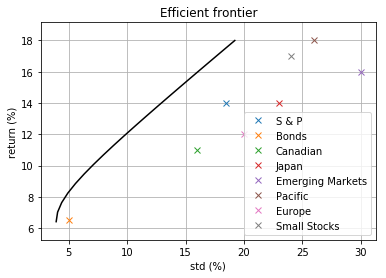

In [30]:
# plot frontier
xlim = ((rmin-0.1*dr), (rmax+0.1*dr))

for i, label in enumerate(assets['Label'].values): 
    plt.plot(np.sqrt(Q[i,i]), r[i], 'x', color=colors[np.mod(i, len(colors))])
plt.plot(np.sqrt(var0), mu0, 'k')
plt.xlabel('std (%)')
plt.ylabel('return (%)')
plt.title('Efficient frontier')
plt.ylim(xlim)
plt.legend(assets['Label'].values)
plt.grid()
plt.show()

## The frontier without short sales

The Optimize API let's one add any constraint to the calculation of the points in the frontier.

For example:

In [31]:
# vector of expected returns
r = assets['Return (%)'].values

# covariance matrix
sigmas = np.diag(assets['STD (%)'].values)
Q = sigmas @ cov.values @ sigmas

# options
options = {
    'number_of_points': 20,
    'short': False
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'options': options
}
sol = client.call('frontier', data)

will produce 20 points on the efficient frontier obtained for portfolios for which short sales are not permitted: 

In [32]:
frontier = sol['frontier']
m = len(frontier)
mu1 = np.zeros((m,))
var1 = np.zeros((m,))
pos1 = np.zeros((m, n))
for i, e in enumerate(frontier):
    point = e['sol']
    mu1[i] = e['mu']
    var1[i] = point['obj']
    pos1[i, :] = point['x']
    if point['obj'] is not None:
        print('  {}. mu = {:.3f}%, std = {:.3f}% ({})'.format(i+1, mu1[i], math.sqrt(var1[i]), point['status']))
    else:
        print('  {}. mu = {:.3f}%, std = --- ({})'.format(i+1, mu1[i], point['status']))

  1. mu = 6.889%, std = 4.874% (optimal)
  2. mu = 7.474%, std = 5.025% (optimal)
  3. mu = 8.059%, std = 5.382% (optimal)
  4. mu = 8.644%, std = 5.886% (optimal)
  5. mu = 9.228%, std = 6.502% (optimal)
  6. mu = 9.813%, std = 7.204% (optimal)
  7. mu = 10.398%, std = 7.969% (optimal)
  8. mu = 10.983%, std = 8.779% (optimal)
  9. mu = 11.568%, std = 9.625% (optimal)
  10. mu = 12.152%, std = 10.497% (optimal)
  11. mu = 12.737%, std = 11.389% (optimal)
  12. mu = 13.322%, std = 12.297% (optimal)
  13. mu = 13.907%, std = 13.217% (optimal)
  14. mu = 14.491%, std = 14.148% (optimal)
  15. mu = 15.076%, std = 15.087% (optimal)
  16. mu = 15.661%, std = 16.032% (optimal)
  17. mu = 16.246%, std = 16.984% (optimal)
  18. mu = 16.830%, std = 17.940% (optimal)
  19. mu = 17.415%, std = 18.900% (optimal)
  20. mu = 18.000%, std = 26.000% (optimal)


Again these points can be combined to produce a plot of the frontier:

In [33]:
rmax = np.max(r)
rmin = np.min((np.min(r), np.min(mu0)))
dr = rmax - rmin
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

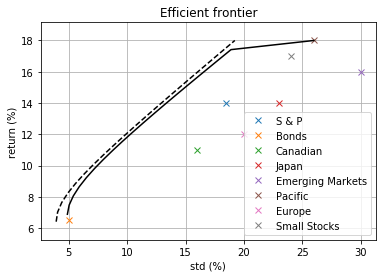

In [34]:
# plot frontier
ylim = ((rmin-0.1*dr), (rmax+0.1*dr))

for i, label in enumerate(assets['Label'].values): 
    plt.plot(np.sqrt(Q[i,i]), r[i], 'x', color=colors[np.mod(i, len(colors))])
plt.plot(np.sqrt(var0), mu0, 'k--')
plt.plot(np.sqrt(var1), mu1, 'k')
plt.xlabel('std (%)')
plt.ylabel('return (%)')
plt.title('Efficient frontier')
plt.ylim(ylim)
plt.legend(assets['Label'].values)
plt.grid()
plt.show()

We have combined in this plot also the standard frontier with short sales (dashed) for comparison.

## A strongly constrained frontier

Consider now the cashflow problem we discussed above in which one would like to invest additional funds to improve their returns without selling any assets. The corresponding frontier can be obtained as follows:

In [35]:
# initial portfolio
x0 = assets['Initial (%)'].values/100

# cashflow
cashflow = 20/100

# options
options = {
    'number_of_points': 20,
    'sell': False
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'x0': x0.tolist(),
    'cashflow': cashflow,
    'options': options
}
sol = client.call('frontier', data)

Note that in this case many returns lead to infeasible portfolios, and the efficient frontier covers a much smaller range of returns:

In [36]:
frontier = sol['frontier']
m = len(frontier)
mu2 = np.zeros((m,))
var2 = np.zeros((m,))
pos2 = np.zeros((m, n))
for i, e in enumerate(frontier):
    point = e['sol']
    mu2[i] = e['mu']
    var2[i] = point['obj']
    pos2[i, :] = point['x']
    if point['obj'] is not None:
        print('  {}. mu = {:.3f}%, std = {:.3f}% ({})'.format(i+1, mu2[i], math.sqrt(var2[i]), point['status']))
    else:
        print('  {}. mu = {:.3f}%, std = --- ({})'.format(i+1, mu2[i], point['status']))

  1. mu = 11.708%, std = 10.331% (optimal)
  2. mu = 12.039%, std = 10.761% (optimal)
  3. mu = 12.371%, std = 11.226% (optimal)
  4. mu = 12.702%, std = 11.711% (optimal)
  5. mu = 13.033%, std = 12.202% (optimal)
  6. mu = 13.364%, std = 12.699% (optimal)
  7. mu = 13.695%, std = --- (infeasible)
  8. mu = 14.026%, std = --- (infeasible)
  9. mu = 14.357%, std = --- (infeasible)
  10. mu = 14.689%, std = --- (infeasible)
  11. mu = 15.020%, std = --- (infeasible)
  12. mu = 15.351%, std = --- (infeasible)
  13. mu = 15.682%, std = --- (infeasible)
  14. mu = 16.013%, std = --- (infeasible)
  15. mu = 16.344%, std = --- (infeasible)
  16. mu = 16.675%, std = --- (infeasible)
  17. mu = 17.007%, std = --- (infeasible)
  18. mu = 17.338%, std = --- (infeasible)
  19. mu = 17.669%, std = --- (infeasible)
  20. mu = 18.000%, std = --- (infeasible)


as visualized in the following plot:

In [37]:
rmax = np.max(r)
rmin = np.min((np.min(r), np.min(mu0)))
dr = rmax - rmin
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

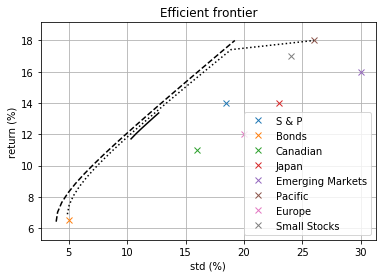

In [38]:
# plot frontier
ylim = ((rmin-0.1*dr), (rmax+0.1*dr))

for i, label in enumerate(assets['Label'].values): 
    plt.plot(np.sqrt(Q[i,i]), r[i], 'x', color=colors[np.mod(i, len(colors))])
plt.plot(np.sqrt(var0), mu0, 'k--')
plt.plot(np.sqrt(var1), mu1, 'k:')
plt.plot(np.sqrt(var2), mu2, 'k')
plt.xlabel('std (%)')
plt.ylabel('return (%)')
plt.title('Efficient frontier')
plt.ylim(ylim)
plt.legend(assets['Label'].values)
plt.grid()
plt.show()

Zooming in:

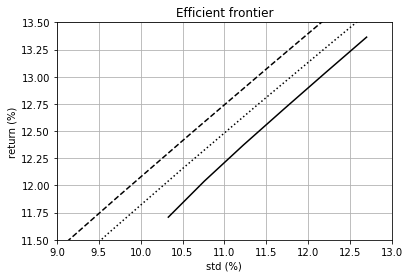

In [39]:
# plot frontier
ylim = (11.5, 13.5)
xlim = (9, 13)

for i, label in enumerate(assets['Label'].values): 
    plt.plot(np.sqrt(Q[i,i]), r[i], 'x', color=colors[np.mod(i, len(colors))])
plt.plot(np.sqrt(var0), mu0, 'k--')
plt.plot(np.sqrt(var1), mu1, 'k:')
plt.plot(np.sqrt(var2), mu2, 'k')
plt.xlabel('std (%)')
plt.ylabel('return (%)')
plt.title('Efficient frontier')
plt.ylim(ylim)
plt.xlim(xlim)
plt.grid()
plt.show()

helps to visualize the three frontiers.

Another interesting visualizion is that of the resulting trades. The following plot shows the frontier, the corresponding positions as a percentage of the total holdings and the corresponding trades as a percentage of the cashflow.

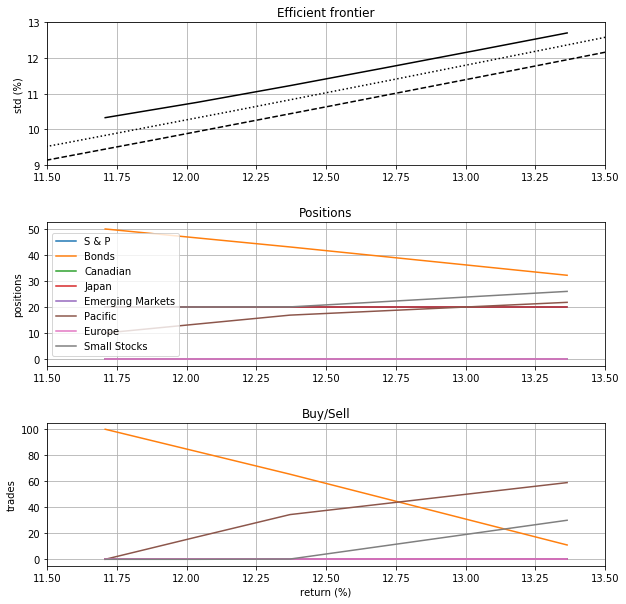

In [40]:
mu = mu2
var = var2
pos = pos2
trades = (pos - x0) / cashflow

# plot frontier
plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
for i, label in enumerate(assets['Label'].values): 
    plt.plot(r[i], np.sqrt(Q[i,i]), 'x', color=colors[np.mod(i, len(colors))])
ax.plot(mu0, np.sqrt(var0), 'k--')
ax.plot(mu1, np.sqrt(var1), 'k:')
ax.plot(mu, np.sqrt(var), 'k')
ax.set_ylabel('std (%)')
ax.set_title('Efficient frontier')
ax.set_xlim(ylim)
ax.set_ylim(xlim)
ax.grid()

ax = plt.subplot(3, 1, 2)
ax.plot(mu, 100*pos)
ax.set_ylabel('positions')
ax.set_title('Positions')
ax.set_xlim(ylim)
ax.legend(assets['Label'].values)
ax.grid()

ax = plt.subplot(3, 1, 3)
ax.plot(mu, 100*trades)
ax.set_xlabel('return (%)')
ax.set_ylabel('trades')
ax.set_title('Buy/Sell')
ax.set_xlim(ylim)
ax.grid()

plt.subplots_adjust(hspace=.4)
plt.show()

Note that the frontier in this case is represented with the coordinates reversed, that is risk versus return, as opposed to the standard return versus risk.